<a href="https://colab.research.google.com/github/AlexeyK12/Natural-Language-Processing-course/blob/main/TB_class_questions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install razdel

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from datasets import Dataset

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from collections import defaultdict
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

import pandas as pd
from razdel import tokenize
from collections import Counter
from tqdm import tqdm
import string

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(12)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
dataset = load_dataset('csv', data_files='dataset_tb.csv')


# переименование и фильтрации столбцов
def rename_and_filter_columns(example):
    return {
        'text': example['вопрос'],
        'label': example['категория']
    }

dataset = dataset.map(rename_and_filter_columns, remove_columns=['вопрос', 'категория', 'ответ'])


# train|test
df = dataset['train'].to_pandas()

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

dataset = {
    'train': train_dataset,
    'test': test_dataset
}


# убираем пропуски
dataset['train'] = dataset['train'].filter(lambda example: example['text'] is not None, num_proc=4)
dataset['test'] = dataset['test'].filter(lambda example: example['text'] is not None, num_proc=4)


# кодирование меток
label2id = defaultdict(lambda: len(label2id))

for example in dataset['train']:
    label2id[example['label']]

id2label = {v: k for k, v in label2id.items()}

print("Label to ID:", label2id)
print("ID to Label:", id2label)


def encode_labels(example):
    example['label'] = label2id[example['label']]
    return example


dataset['train'] = dataset['train'].map(encode_labels)
dataset['test'] = dataset['test'].map(encode_labels)

Filter (num_proc=4):   0%|          | 0/2272 [00:00<?, ? examples/s]

Filter (num_proc=4):   0%|          | 0/569 [00:00<?, ? examples/s]

Label to ID: defaultdict(<function <lambda> at 0x781b89f394e0>, {'Новые длительности смен': 0, 'Шаблон доступности': 1, 'Настройка системы': 2, 'Документы состояний': 3, 'Вопрос по нагрузке': 4, 'Секции не заполнена/не корректна': 5, 'Вопрос по работе на портале планирования': 6, 'Ограничение по ТК РФ': 7, 'Общие вопросы': 8, 'Внешний персонал': 9, 'Кадровые документы': 10, 'Ошибка планера': 11, 'Должности не участвуют в автопланировании': 12, 'Нет вопроса': 13})
ID to Label: {0: 'Новые длительности смен', 1: 'Шаблон доступности', 2: 'Настройка системы', 3: 'Документы состояний', 4: 'Вопрос по нагрузке', 5: 'Секции не заполнена/не корректна', 6: 'Вопрос по работе на портале планирования', 7: 'Ограничение по ТК РФ', 8: 'Общие вопросы', 9: 'Внешний персонал', 10: 'Кадровые документы', 11: 'Ошибка планера', 12: 'Должности не участвуют в автопланировании', 13: 'Нет вопроса'}


Map:   0%|          | 0/2267 [00:00<?, ? examples/s]

Map:   0%|          | 0/566 [00:00<?, ? examples/s]

In [3]:
# нормализуем, токенезируем и создаём словарь
words = Counter()

for example in tqdm(dataset['train']['text']):
    processed_text = example.lower().translate(str.maketrans('', '', string.punctuation))
    for word in tokenize(processed_text):
        words[word.text] += 1

vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 10
for word, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(word)

print(f'Размер словаря: {len(vocab)}')

word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

print(list(vocab)[:20])

100%|██████████| 2267/2267 [00:00<00:00, 11091.31it/s]

Размер словаря: 467
['период', 'времени', 'выводит', 'главной', 'если', 'неделя', '17', 'ставит', 'запланировано', 'расчет', 'выходные', '8', 'субботу', '9301800', '11', 'потребность', 'дневные', 'его', 'идет', 'еще']


In [4]:
# класс база
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [5]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)


def evaluate(model, eval_dataloader) -> float:
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy


# архитектура GRU с 2мя слоями
class CharLM_v2_MultiLayer(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 14,
        aggregation_type: str = 'max', num_layers: int = 2
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))
        prediction = self.projection(self.non_lin(output))

        return prediction


model = CharLM_v2_MultiLayer(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [6]:
num_epoch = 15
eval_steps = len(train_dataloader) // 2

losses_type = {}
acc_type = {}

for aggregation_type in ['max', 'mean']:
    print(f"Starting training for {aggregation_type}")
    losses = []
    acc = []

    model = CharLM_v2_MultiLayer(
        hidden_dim=256, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'].to(device))
            loss = criterion(logits, batch['label'].to(device))
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                accuracy = evaluate(model, eval_dataloader)
                acc.append(accuracy)
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    losses_type[aggregation_type] = losses
    acc_type[aggregation_type] = acc

Starting training for max


Training epoch 14:: 100%|██████████| 71/71 [00:07<00:00,  9.70it/s]


Starting training for mean


Training epoch 14:: 100%|██████████| 71/71 [00:07<00:00,  9.88it/s]


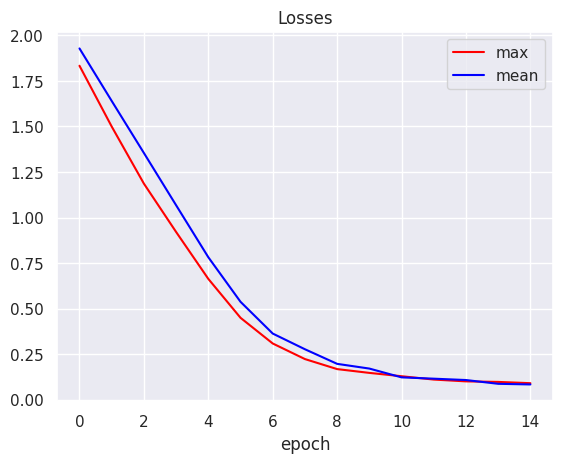

In [7]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 63.46
Лучшая accuracy для подхода mean: 61.00


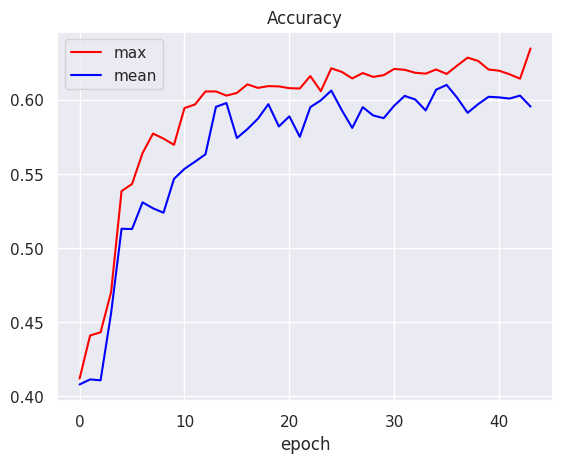

In [8]:
for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
    plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

plt.title('Accuracy')
plt.xlabel("epoch")
plt.legend()
plt.show()

# BERT

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import classification_report, accuracy_score

# токенизатор и BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label2id)).to(device)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

dataset['train'] = dataset['train'].map(tokenize_function, batched=True)
dataset['test'] = dataset['test'].map(tokenize_function, batched=True)

# тензоры
def collate_fn(batch):
    return {
        'input_ids': torch.stack([torch.tensor(item['input_ids']) for item in batch]),
        'attention_mask': torch.stack([torch.tensor(item['attention_mask']) for item in batch]),
        'label': torch.tensor([item['label'] for item in batch])
    }

train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=32, collate_fn=collate_fn)
eval_dataloader = DataLoader(dataset['test'], batch_size=32, collate_fn=collate_fn)


# оценка модели
def evaluate(model, eval_dataloader):
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad():
        for batch in eval_dataloader:
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['label'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    return accuracy, true_labels, predictions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2267 [00:00<?, ? examples/s]

Map:   0%|          | 0/566 [00:00<?, ? examples/s]

In [10]:
# функция обучения с валидацией
def run_BERT(optimizer, num_epoch=3):
    train_losses = []
    eval_accuracies = []

    for epoch in range(num_epoch):
        model.train()
        epoch_loss = 0

        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['label'].to(device)
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_epoch_loss)

        accuracy, true_labels, predictions = evaluate(model, eval_dataloader)
        eval_accuracies.append(accuracy)

        print(f'Epoch {epoch + 1}: Loss = {avg_epoch_loss:.4f}, Accuracy = {accuracy:.4f}')


    print(classification_report(true_labels, predictions, target_names=list(id2label.values())))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(eval_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.show()

Training epoch 0:: 100%|██████████| 71/71 [01:32<00:00,  1.30s/it]


Epoch 1: Loss = 1.3817, Accuracy = 0.5177


Training epoch 1:: 100%|██████████| 71/71 [01:31<00:00,  1.29s/it]


Epoch 2: Loss = 1.1556, Accuracy = 0.5742


Training epoch 2:: 100%|██████████| 71/71 [01:31<00:00,  1.29s/it]


Epoch 3: Loss = 0.9603, Accuracy = 0.5565
                                           precision    recall  f1-score   support

                  Новые длительности смен       0.44      0.44      0.44        27
                       Шаблон доступности       0.61      0.75      0.68       238
                        Настройка системы       0.70      0.34      0.46       117
                      Документы состояний       0.37      0.61      0.46        28
                       Вопрос по нагрузке       0.46      0.80      0.58        54
         Секции не заполнена/не корректна       0.00      0.00      0.00        11
 Вопрос по работе на портале планирования       0.00      0.00      0.00         9
                     Ограничение по ТК РФ       0.21      0.14      0.17        21
                            Общие вопросы       0.00      0.00      0.00        14
                         Внешний персонал       0.00      0.00      0.00         6
                       Кадровые документы   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


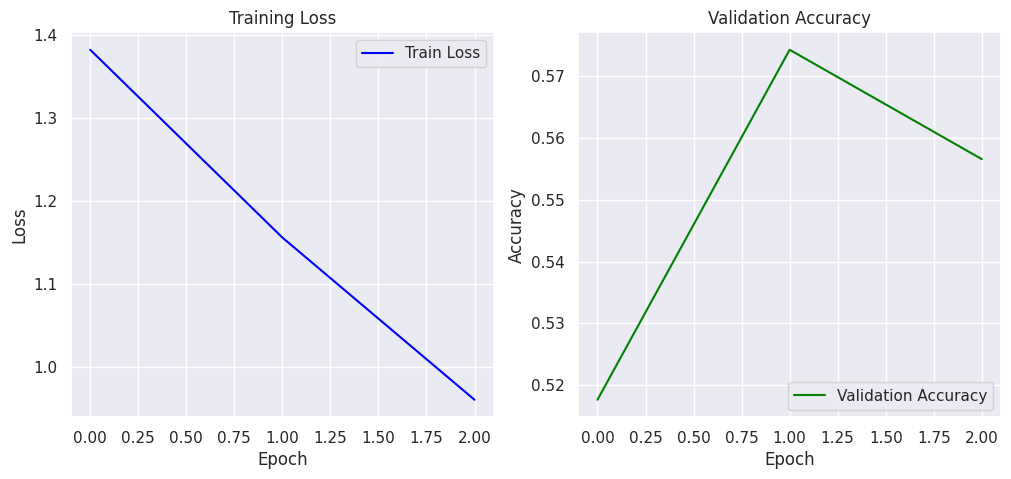

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
run_BERT(optimizer=optimizer)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training epoch 0:: 100%|██████████| 71/71 [01:32<00:00,  1.30s/it]


Epoch 1: Loss = 0.8440, Accuracy = 0.6078


Training epoch 1:: 100%|██████████| 71/71 [01:31<00:00,  1.28s/it]


Epoch 2: Loss = 0.6645, Accuracy = 0.6148


Training epoch 2:: 100%|██████████| 71/71 [01:31<00:00,  1.28s/it]


Epoch 3: Loss = 0.5555, Accuracy = 0.6042
                                           precision    recall  f1-score   support

                  Новые длительности смен       0.58      0.56      0.57        27
                       Шаблон доступности       0.71      0.66      0.69       238
                        Настройка системы       0.57      0.59      0.58       117
                      Документы состояний       0.49      0.61      0.54        28
                       Вопрос по нагрузке       0.53      0.74      0.62        54
         Секции не заполнена/не корректна       0.33      0.45      0.38        11
 Вопрос по работе на портале планирования       0.00      0.00      0.00         9
                     Ограничение по ТК РФ       0.32      0.48      0.38        21
                            Общие вопросы       0.50      0.29      0.36        14
                         Внешний персонал       0.00      0.00      0.00         6
                       Кадровые документы   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


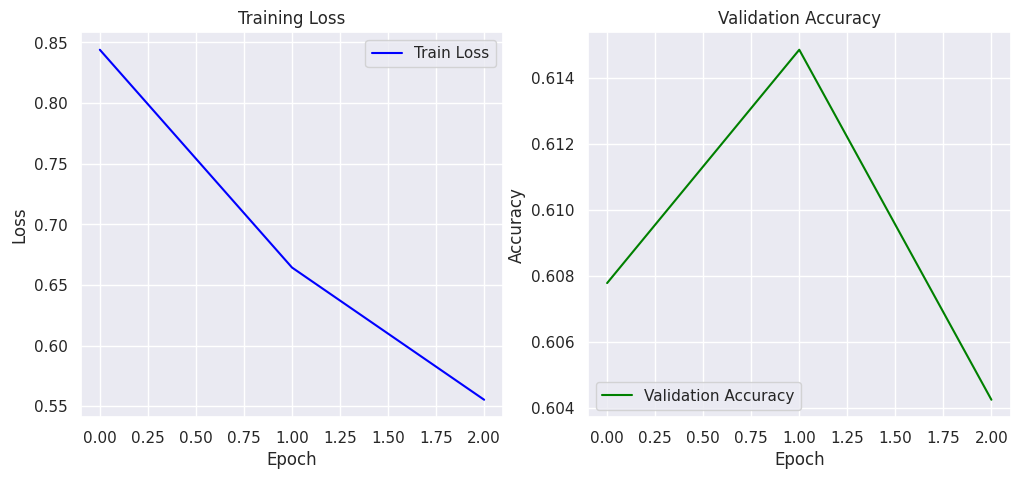

In [29]:
optimizer = AdamW(model.parameters(), lr=5e-5)
run_BERT(optimizer=optimizer)

Training epoch 0:: 100%|██████████| 71/71 [01:29<00:00,  1.26s/it]


Epoch 1: Loss = 1.8078, Accuracy = 0.4205


Training epoch 1:: 100%|██████████| 71/71 [01:29<00:00,  1.26s/it]


Epoch 2: Loss = 1.9848, Accuracy = 0.4205


Training epoch 2:: 100%|██████████| 71/71 [01:29<00:00,  1.26s/it]


Epoch 3: Loss = 1.9802, Accuracy = 0.4205
                                           precision    recall  f1-score   support

                  Новые длительности смен       0.00      0.00      0.00        27
                       Шаблон доступности       0.42      1.00      0.59       238
                        Настройка системы       0.00      0.00      0.00       117
                      Документы состояний       0.00      0.00      0.00        28
                       Вопрос по нагрузке       0.00      0.00      0.00        54
         Секции не заполнена/не корректна       0.00      0.00      0.00        11
 Вопрос по работе на портале планирования       0.00      0.00      0.00         9
                     Ограничение по ТК РФ       0.00      0.00      0.00        21
                            Общие вопросы       0.00      0.00      0.00        14
                         Внешний персонал       0.00      0.00      0.00         6
                       Кадровые документы   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


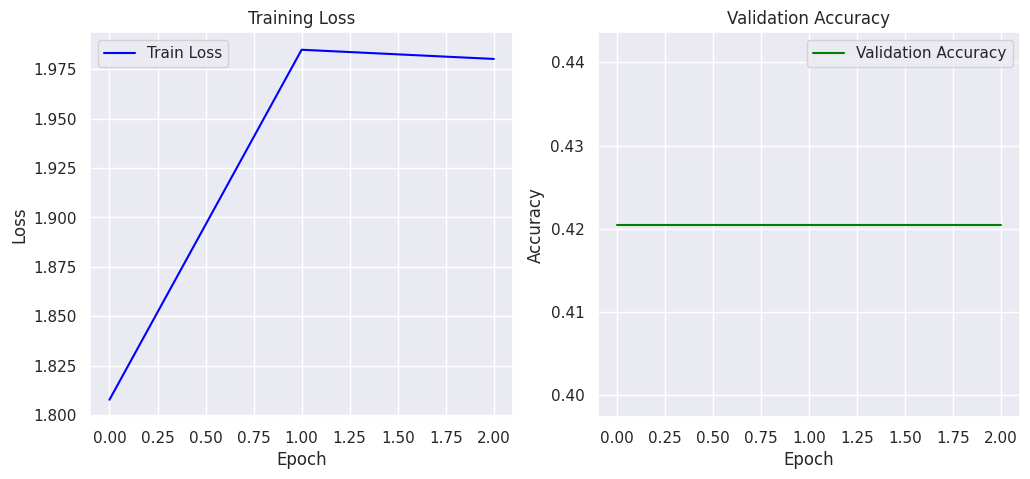

In [30]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
run_BERT(optimizer=optimizer)

Training epoch 0:: 100%|██████████| 71/71 [01:29<00:00,  1.27s/it]


Epoch 1: Loss = 2.5576, Accuracy = 0.4205


Training epoch 1:: 100%|██████████| 71/71 [01:30<00:00,  1.27s/it]


Epoch 2: Loss = 2.0809, Accuracy = 0.4205


Training epoch 2:: 100%|██████████| 71/71 [01:29<00:00,  1.27s/it]


Epoch 3: Loss = 2.0574, Accuracy = 0.4205
                                           precision    recall  f1-score   support

                  Новые длительности смен       0.00      0.00      0.00        27
                       Шаблон доступности       0.42      1.00      0.59       238
                        Настройка системы       0.00      0.00      0.00       117
                      Документы состояний       0.00      0.00      0.00        28
                       Вопрос по нагрузке       0.00      0.00      0.00        54
         Секции не заполнена/не корректна       0.00      0.00      0.00        11
 Вопрос по работе на портале планирования       0.00      0.00      0.00         9
                     Ограничение по ТК РФ       0.00      0.00      0.00        21
                            Общие вопросы       0.00      0.00      0.00        14
                         Внешний персонал       0.00      0.00      0.00         6
                       Кадровые документы   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


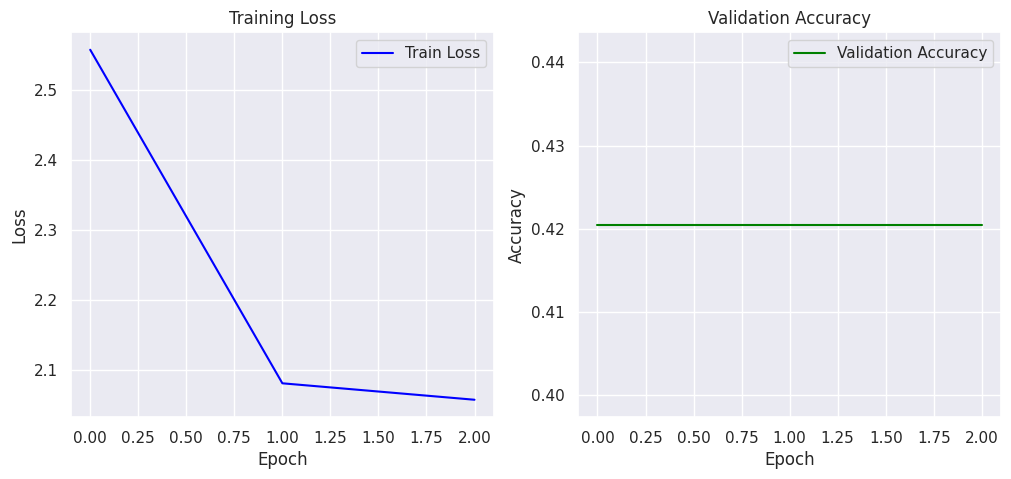

In [31]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99)
run_BERT(optimizer=optimizer)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training epoch 0:: 100%|██████████| 71/71 [01:31<00:00,  1.29s/it]


Epoch 1: Loss = 1.9483, Accuracy = 0.4276


Training epoch 1:: 100%|██████████| 71/71 [01:31<00:00,  1.29s/it]


Epoch 2: Loss = 1.7969, Accuracy = 0.4735


Training epoch 2:: 100%|██████████| 71/71 [01:31<00:00,  1.29s/it]


Epoch 3: Loss = 1.6379, Accuracy = 0.4647


Training epoch 3:: 100%|██████████| 71/71 [01:30<00:00,  1.28s/it]


Epoch 4: Loss = 1.4619, Accuracy = 0.5035


Training epoch 4:: 100%|██████████| 71/71 [01:30<00:00,  1.28s/it]


Epoch 5: Loss = 1.2798, Accuracy = 0.5495


Training epoch 5:: 100%|██████████| 71/71 [01:30<00:00,  1.28s/it]


Epoch 6: Loss = 1.0946, Accuracy = 0.5777


Training epoch 6:: 100%|██████████| 71/71 [01:30<00:00,  1.28s/it]


Epoch 7: Loss = 0.9253, Accuracy = 0.5707


Training epoch 7:: 100%|██████████| 71/71 [01:30<00:00,  1.28s/it]


Epoch 8: Loss = 0.7543, Accuracy = 0.5936


Training epoch 8:: 100%|██████████| 71/71 [01:31<00:00,  1.28s/it]


Epoch 9: Loss = 0.6487, Accuracy = 0.5742


Training epoch 9:: 100%|██████████| 71/71 [01:30<00:00,  1.28s/it]


Epoch 10: Loss = 0.5000, Accuracy = 0.5901
                                           precision    recall  f1-score   support

                  Новые длительности смен       0.38      0.59      0.46        27
                       Шаблон доступности       0.79      0.58      0.67       238
                        Настройка системы       0.55      0.69      0.61       117
                      Документы состояний       0.38      0.64      0.47        28
                       Вопрос по нагрузке       0.59      0.76      0.67        54
         Секции не заполнена/не корректна       0.35      0.55      0.43        11
 Вопрос по работе на портале планирования       0.33      0.11      0.17         9
                     Ограничение по ТК РФ       0.31      0.38      0.34        21
                            Общие вопросы       0.33      0.21      0.26        14
                         Внешний персонал       0.00      0.00      0.00         6
                       Кадровые документы  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


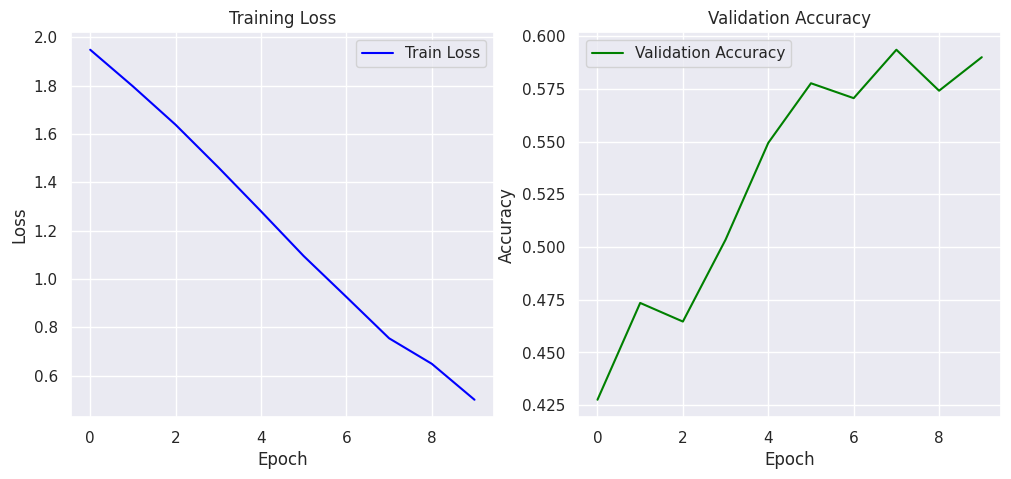

In [11]:
optimizer = AdamW(model.parameters(), lr=5e-5)
run_BERT(optimizer=optimizer, num_epoch=10)